<img src="https://scientists4future-dortmund.de/assets/img/banner_web.svg" width="100%" alt="banner">


# Analyse öffentlicher Daten zur Meereisbedeckung an den Polen


Die Daten stammen aus dieser Veröffentlichung 

> Fetterer, F., K. Knowles, W. N. Meier, M. Savoie, and A. K. Windnagel. 2017, updated daily. Sea Ice Index, Version 3. northern and southern hemisphere csv data. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi: https://doi.org/10.7265/N5K072F8. as of 2019-06-26T16:27:00.

Download Links:
* ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv
* ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
from scipy.stats import sem
from sklearn.ensemble import GradientBoostingRegressor

from keras.layers import LSTM, Dense, TimeDistributed
from keras.models import Sequential

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Using TensorFlow backend.


In [2]:
def read_icedata(path):
    # skip column containing units
    df = pd.read_csv(path, skiprows=[1])
    
    # remove whitespace from column names, make lowercase
    df.columns = [c.strip().lower() for c in df.columns]
    
    # convert Year/Month/Date columns into a timestamp
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    # Use date as Index
    df.set_index('date', inplace=True)
    
    # remove unuseful columns
    df.drop(['source data', 'year', 'month', 'day'], axis=1, inplace=True)
    
    
    # only values every two days before 1990, resample and interpolate to have values for every day
    df = df.resample('1d').interpolate('linear', limit=1)
    return df

dfs = read_icedata('data/2019-11-21/S_seaice_extent_daily_v3.0.csv')
dfn = read_icedata('data/2019-11-21/N_seaice_extent_daily_v3.0.csv')

df = dfs.join(dfn, lsuffix='_antarctic', rsuffix='_arctic', how='outer')

In [3]:
df['extent_total'] = df.extent_antarctic + df.extent_arctic

In [4]:
df.describe()

,extent_antarctic,missing_antarctic,extent_arctic,missing_arctic,extent_total
count,14960.000000,1.496000e+04,14960.000000,14960.0,14960.000000
mean,11.646787,6.016043e-07,11.413947,0.0,23.060734
std,5.635202,3.370575e-05,3.270261,0.0,2.917391
min,2.080000,0.000000e+00,3.340000,0.0,16.064000
25%,6.041000,0.000000e+00,8.706000,0.0,20.542000
50%,12.594500,0.000000e+00,12.107000,0.0,23.838500
75%,17.198000,0.000000e+00,14.276000,0.0,25.400000
max,20.201000,3.000000e-03,16.635000,0.0,28.311000


In [5]:
df.index.min(), df.index.max()

(Timestamp('1978-10-26 00:00:00'), Timestamp('2019-11-19 00:00:00'))

In [6]:
df.dropna().index.to_series().diff().value_counts()

1 days     14958
41 days        1
Name: date, dtype: int64

In [7]:
df.head()

,extent_antarctic,missing_antarctic,extent_arctic,missing_arctic,extent_total
date,,,,,
1978-10-26,17.6240,0.0,10.2310,0.0,27.855
1978-10-27,17.7135,0.0,10.3255,0.0,28.039
1978-10-28,17.8030,0.0,10.4200,0.0,28.223
1978-10-29,17.7365,0.0,10.4885,0.0,28.225
1978-10-30,17.6700,0.0,10.5570,0.0,28.227


In [8]:
df.corr()

,extent_antarctic,missing_antarctic,extent_arctic,missing_arctic,extent_total
extent_antarctic,1.000000,0.008235,-0.920824,NaN,0.899389
missing_antarctic,0.008235,1.000000,-0.015939,NaN,-0.001960
extent_arctic,-0.920824,-0.015939,1.000000,NaN,-0.657700
missing_arctic,NaN,NaN,NaN,NaN,NaN
extent_total,0.899389,-0.001960,-0.657700,NaN,1.000000


## Daten visualisieren

Wir plotten einfach erstmal die Menge Eis gegen das Datum

Text(0, 0.5, 'sea ice coverage / $10^6$ km$^2$')

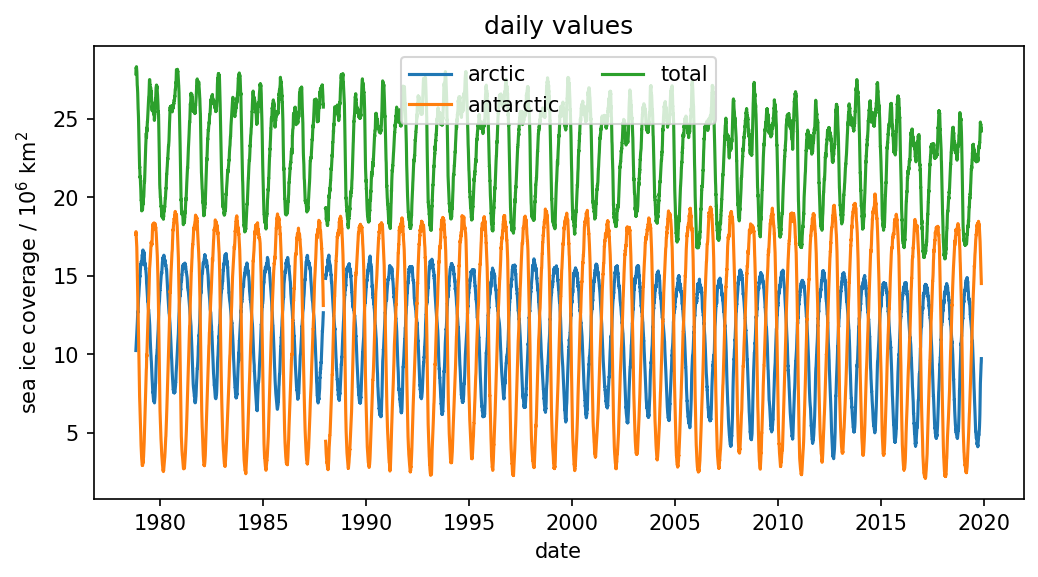

In [9]:
plt.figure(figsize=(8,4), dpi=150)

subset = df  # .loc['2018-01-01':]

for label in ('arctic', 'antarctic', 'total'):    
    plt.plot(subset.index, subset['extent_' + label], label=label)

plt.legend(ncol=2, loc='upper center')
plt.title('daily values')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')

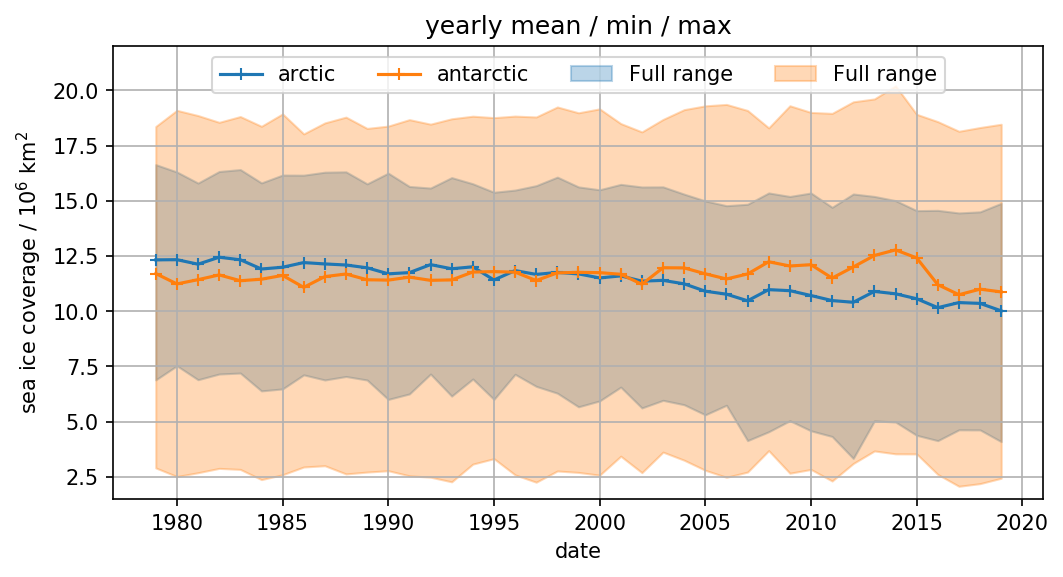

In [12]:
plt.figure(figsize=(8,4), dpi=150)


for label in ['arctic', 'antarctic']:
    
    # let's take only full years
    full_years = df.loc['1979-01-01':'2020']
    
    # aggregate data of each year, using mean, min, max
    by_year = full_years.groupby(full_years.index.year)['extent_' + label].agg(['mean', 'min', 'max'])
    
    l, = plt.plot(by_year.index, by_year['mean'], label=label, marker='+')

    plt.fill_between(
        by_year.index,
        by_year['min'],
        by_year['max'],
        alpha=0.3,
        color=l.get_color(),
        label="Full range"
    )

plt.legend(ncol=4,loc='upper center')
plt.title('yearly mean / min / max')
plt.xlabel('date')
plt.ylim(1.5, 22)
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.grid()

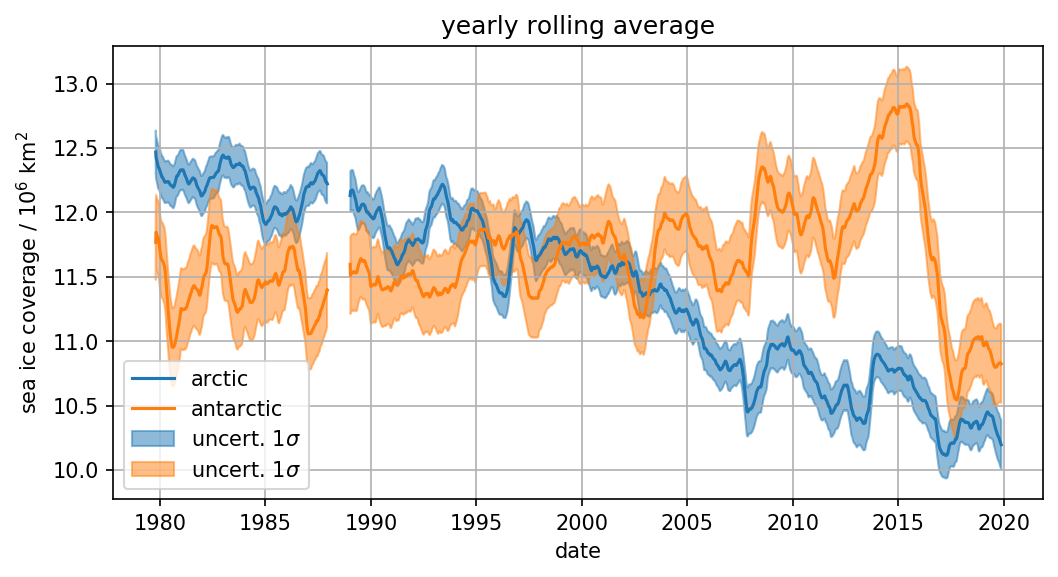

In [14]:
plt.figure(figsize=(8,4), dpi=150)

for label in ['arctic', 'antarctic']:
    
    # do not show data where less than 300 points were averaged
    rolled = df['extent_' + label].rolling('365d', min_periods=360)
    
    ice_mean = rolled.mean()
    # std error of the mean
    ice_mean_err = rolled.agg(sem)
    
    l, = plt.plot(ice_mean.index, ice_mean, label=label)

    plt.fill_between(
        ice_mean.index,
        ice_mean - ice_mean_err,
        ice_mean + ice_mean_err,
        alpha=0.5,
        color=l.get_color(),
        label="uncert. 1$\sigma$"
    )

plt.legend()
plt.title('yearly rolling average')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.grid()

Text(0, 0.5, 'sea ice coverage / $10^6$ km$^2$')

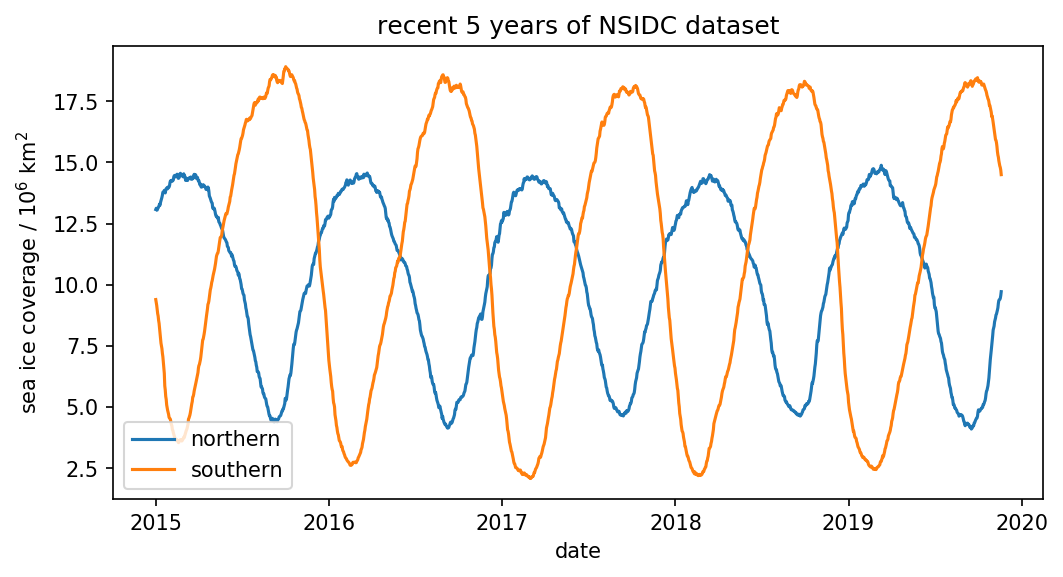

In [15]:
plt.figure(figsize=(8,4), dpi=150)

last_5 = df.loc['2015-01-01':]

plt.plot(last_5.index, last_5['extent_arctic'], label='northern')
plt.plot(last_5.index, last_5['extent_antarctic'], label='southern')

plt.legend()
plt.title('recent 5 years of NSIDC dataset')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')

Text(0, 0.5, 'sea ice coverage / $10^6$ km$^2$')

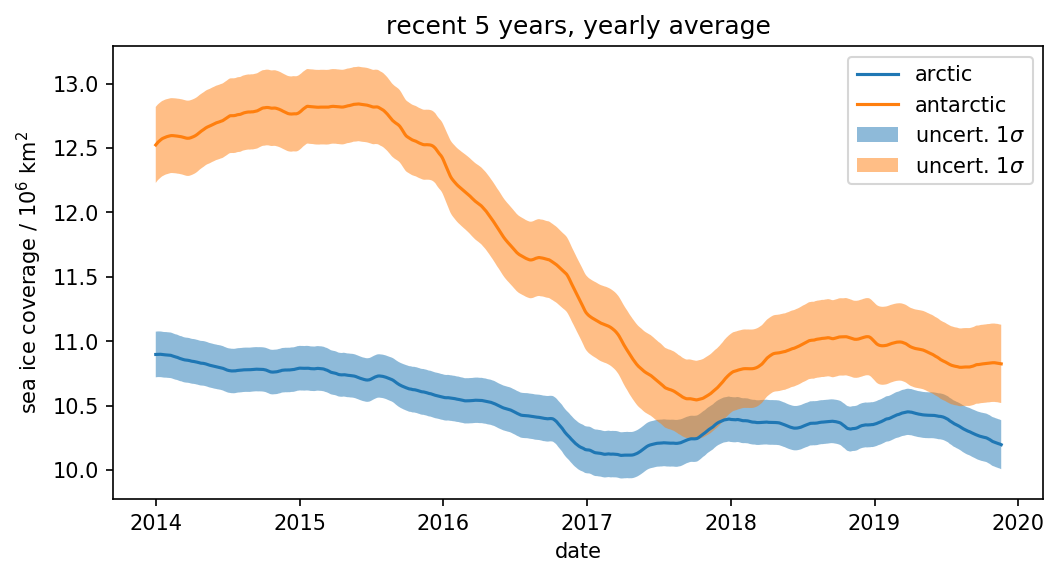

In [16]:
plt.figure(figsize=(8,4), dpi=150)


last_5_r = df['2013-01-01':].rolling('365d', min_periods=365).agg(['mean', 'count', 'std', sem])


for label in ['arctic', 'antarctic']:
    k = 'extent_' + label
    plt.plot(last_5_r.index, last_5_r[k, 'mean'], label=label)

    plt.fill_between(
        last_5_r.index,
        last_5_r[k, 'mean'] - last_5_r[k, 'sem'] ,
        last_5_r[k, 'mean'] + last_5_r[k, 'sem'] ,
        alpha=0.5,
        label="uncert. 1$\sigma$"
    )

plt.legend()
plt.title('recent 5 years, yearly average')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')

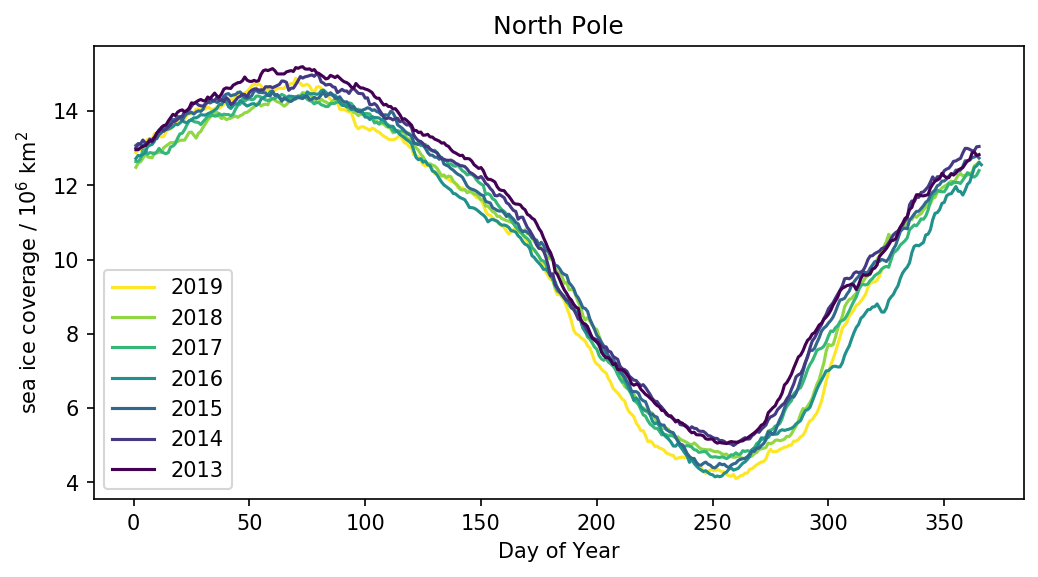

In [17]:
plt.figure(figsize=(8,4), dpi=150)
plt.title('North Pole')

colors = matplotlib.cm.get_cmap('viridis', 7).colors[::-1]

for y, color in zip(range(2019, 2012, -1), colors):
    sl = slice(f'{y}-01-01', f'{y}-12-31')
    
    plt.plot(
        df[sl].index.dayofyear,
        df[sl]['extent_arctic'],
        color=color,
        label=y,
    )

plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.xlabel('Day of Year')
plt.legend()

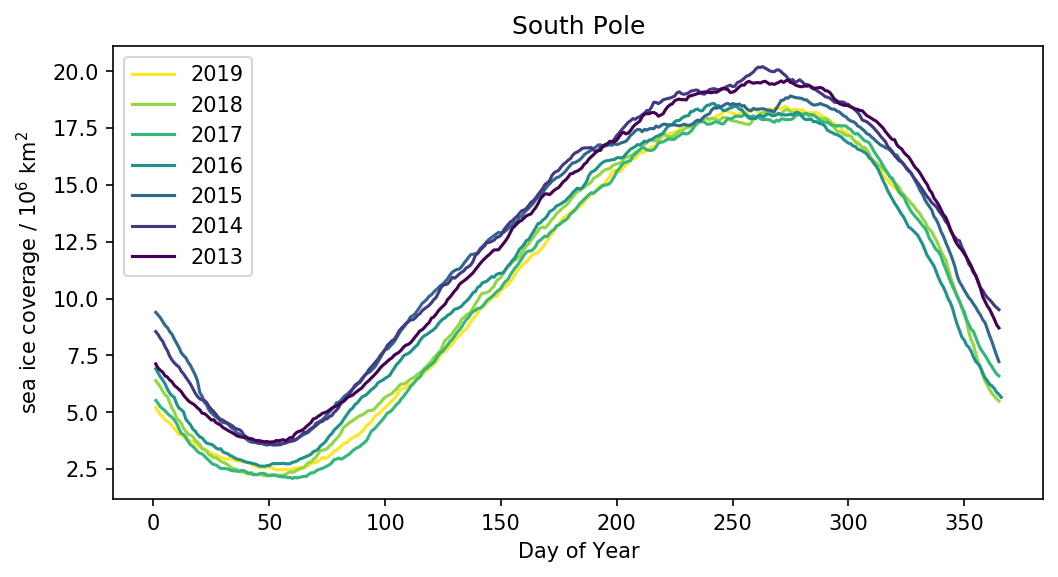

In [18]:
plt.figure(figsize=(8,4), dpi=150)
plt.title('South Pole')

for y, color in zip(range(2019, 2012, -1), colors):
    sl = slice(f'{y}-01-01', f'{y}-12-31')
    
    plt.plot(
        df[sl].index.dayofyear,
        df[sl]['extent_antarctic'],
        label=y,
        color=color,
    )
    
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.xlabel('Day of Year')
plt.legend()

In [19]:
def plot_critical_years(df, start, end, area='arctic'):
    plt.figure(figsize=(8,4), dpi=150)
    
    def percentile(p):
        def calc_perc(s):
            return np.nanpercentile(s, p)
        
        calc_perc.__name__ = f'{p}%'
        return calc_perc

    before = df[:f'{start - 1}-12-31']
    before = before.groupby(before.index.dayofyear)
    before = before['extent_' + area].agg(['mean', 'std', percentile(16), percentile(84)])

    plt.plot(
        before.index,
        before['mean'],
        label=f'daily avg until {start}'
    )

    plt.fill_between(
        before.index,
        before['16%'],
        before['84%'],
        alpha=0.5,
        label='1-σ quantiles'
    )

    colors = matplotlib.cm.get_cmap('viridis', end - start).colors
    for y, color in zip(range(start, end), colors):
        sl = slice(f'{y}-01-01', f'{y}-12-31') 
        plt.plot(
            df[sl].index.dayofyear,
            df[sl]['extent_' + area],
            label=y,
            color=color,
        )

    plt.legend()
    plt.xlabel('days of year')
    plt.ylabel('sea ice coverage / $10^6$ km$^2$')

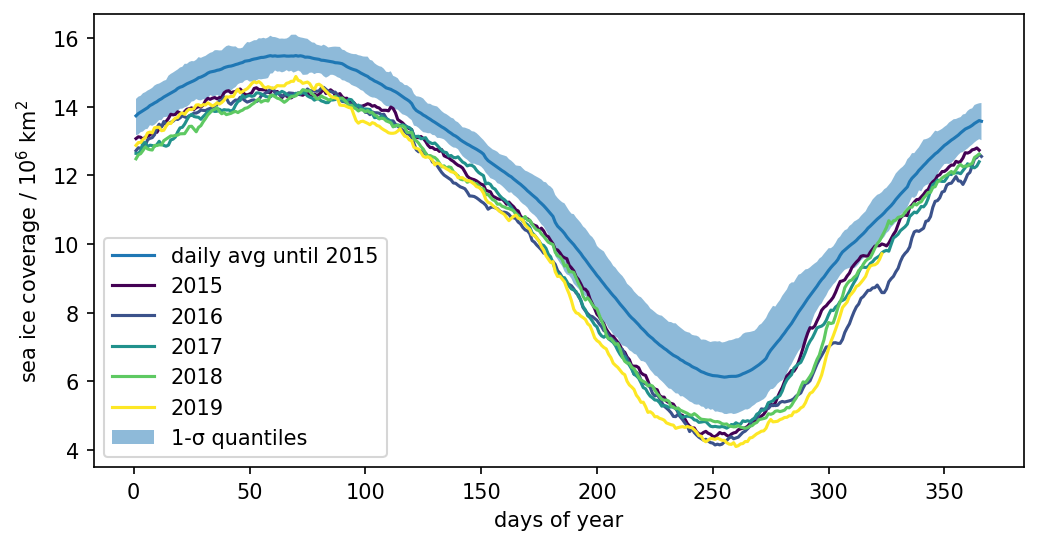

In [20]:
plot_critical_years(df, 2015, 2020)

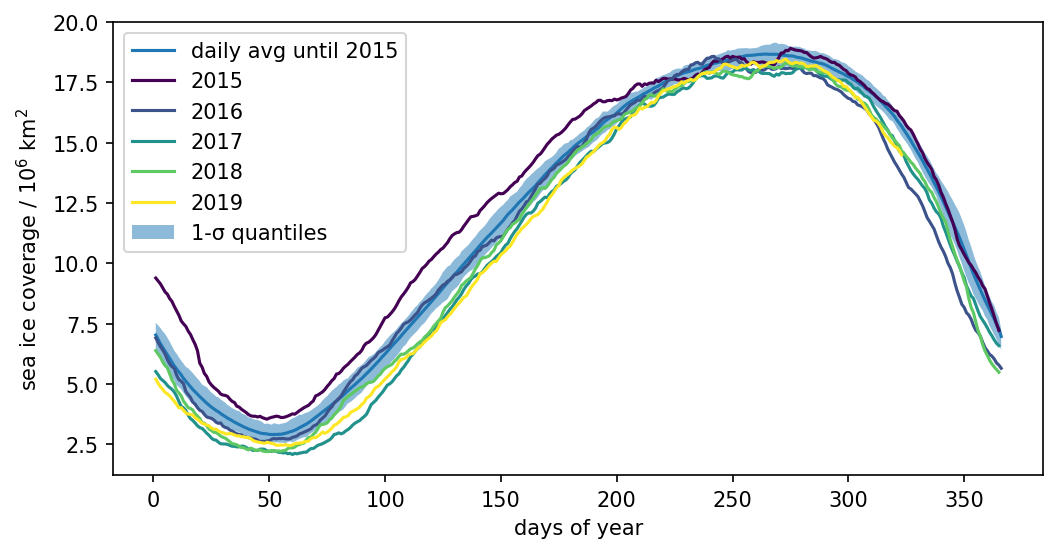

In [21]:
plot_critical_years(df, 2015, 2020, area='antarctic')

## Add more data sources

In [22]:
def read_temp_anomaly(path):
    df = pd.read_csv(path, sep='\s+', header=None,
                     usecols=[0, 1, 10, 11],  # use date, data, and full-model 95% uncertainty intervals
                      names=['date', 'data', 'lower', 'upper'])
    # Use date as index
    df.set_index(pd.to_datetime(df.date), inplace=True)
    
    # drop unneeded cols
    df.drop('date', axis=1, inplace=True)
    return df

anomn = read_temp_anomaly('data/2019-11-26/HadCRUT.4.6.0.0.monthly_nh.txt')
anoms = read_temp_anomaly('data/2019-11-26/HadCRUT.4.6.0.0.monthly_sh.txt')

anom = anomn.join(anoms, lsuffix='_north', rsuffix='_south', how='outer')

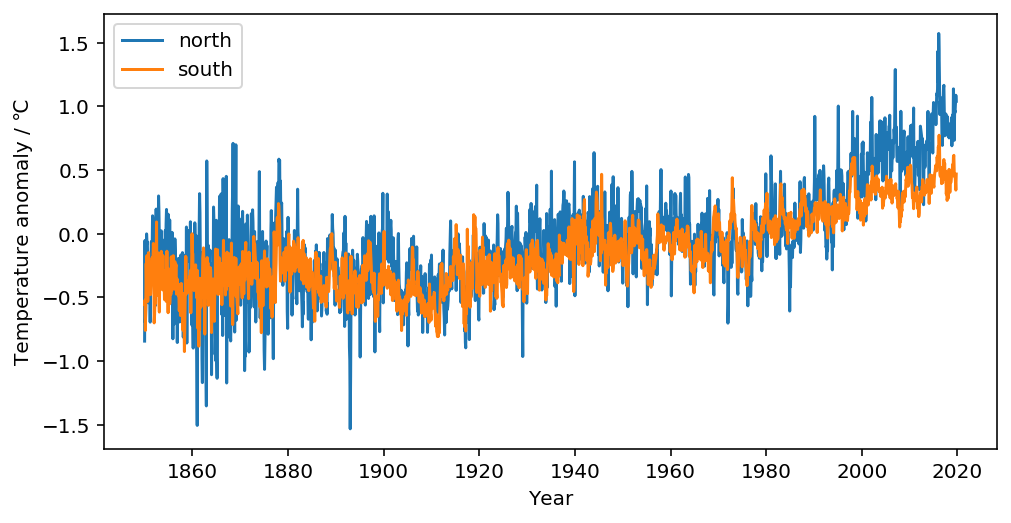

In [254]:
plt.figure(figsize=(8, 4), dpi=144)

sub = anom #.loc['1978':'2020']

for lab in ['north', 'south']:
    plt.plot(sub.index, sub[f'data_{lab}'], label=lab)

plt.xlabel('Year')
plt.ylabel('Temperature anomaly / ℃')
plt.legend(loc='best')
plt.show()

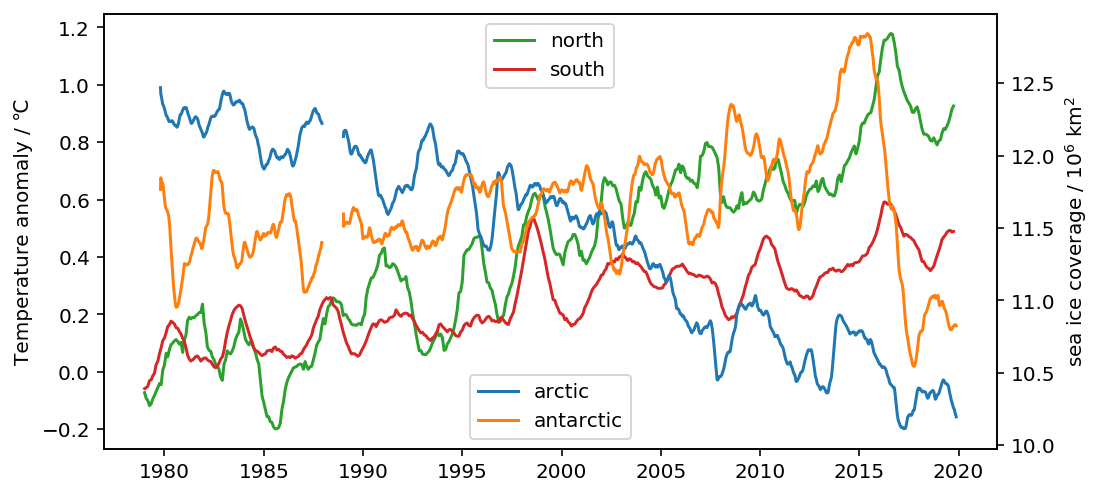

In [24]:
plt.figure(figsize=(8, 4), dpi=144)

sub = slice('1979', '2020')

for i, lab in enumerate(['north', 'south']):
    rolled = anom[f'data_{lab}'].rolling(12)
    anomaly_mean = rolled.mean()
    plt.plot(anomaly_mean.loc[sub].index, anomaly_mean.loc[sub], label=lab, color=f'C{i+2}')

plt.ylabel('Temperature anomaly / ℃')
plt.legend(loc='upper center')

ax2 = plt.gca().twinx()

for label in ['arctic', 'antarctic']:
    rolled = df['extent_' + label].rolling('365d', min_periods=360)
    
    ice_mean = rolled.mean()

    plt.plot(ice_mean.loc[sub].index, ice_mean.loc[sub], label=label)

plt.legend(loc='lower center')    
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.xlabel('Year')
plt.show()

In [134]:
combined = pd.merge(
    df.loc[slice('1979-01-01', None), ['extent_antarctic', 'extent_arctic', 'extent_total']].resample('BMS').mean(),
    anom.loc['1979-01-01':],
    left_index=True, right_index=True
).dropna()

In [196]:
combined['rolling_mean_extent'] = combined['extent_total'].rolling(12).mean()

In [197]:
combined['rolling_mean_extent']

date
1979-01-01          NaN
1979-02-01          NaN
1979-03-01          NaN
1979-05-01          NaN
1979-06-01          NaN
                ...    
2019-04-01    19.981039
2019-05-01    20.294459
2019-07-01    20.841776
2019-08-01    21.220886
2019-10-01    21.383939
Name: rolling_mean_extent, Length: 350, dtype: float64

In [198]:
corr.style.background_gradient(cmap='coolwarm')

,extent_antarctic,extent_arctic,extent_total,data_north,lower_north,upper_north,data_south,lower_south,upper_south
extent_antarctic,1,-0.680972,0.677165,0.193213,0.217025,0.169206,0.157857,0.0626112,0.244905
extent_arctic,-0.680972,1,0.0777264,-0.747527,-0.758983,-0.735308,-0.653078,-0.587823,-0.708302
extent_total,0.677165,0.0777264,1,-0.48808,-0.467172,-0.508485,-0.441311,-0.50541,-0.378292
data_north,0.193213,-0.747527,-0.48808,1,0.999507,0.999517,0.910778,0.899682,0.911756
lower_north,0.217025,-0.758983,-0.467172,0.999507,1,0.998054,0.909934,0.896106,0.913424
upper_north,0.169206,-0.735308,-0.508485,0.999517,0.998054,1,0.910671,0.902286,0.909169
data_south,0.157857,-0.653078,-0.441311,0.910778,0.909934,0.910671,1,0.993097,0.994026
lower_south,0.0626112,-0.587823,-0.50541,0.899682,0.896106,0.902286,0.993097,1,0.974432
upper_south,0.244905,-0.708302,-0.378292,0.911756,0.913424,0.909169,0.994026,0.974432,1


In [199]:
corr = combined.rolling('365d').mean().dropna().corr()
corr.style.background_gradient(cmap='coolwarm')

,extent_antarctic,extent_arctic,extent_total,data_north,lower_north,upper_north,data_south,lower_south,upper_south,rolling_mean_extent
extent_antarctic,1,-0.521644,0.673012,0.0561133,0.0753946,0.0369129,0.0455885,-0.0319361,0.119088,0.352051
extent_arctic,-0.521644,1,0.279953,-0.754296,-0.761416,-0.746625,-0.66085,-0.613893,-0.702103,0.471443
extent_total,0.673012,0.279953,1,-0.59078,-0.575256,-0.605734,-0.521612,-0.568137,-0.474671,0.80485
data_north,0.0561133,-0.754296,-0.59078,1,0.999616,0.999632,0.906346,0.901004,0.904632,-0.533451
lower_north,0.0753946,-0.761416,-0.575256,0.999616,1,0.998502,0.905927,0.898592,0.906073,-0.520771
upper_north,0.0369129,-0.746625,-0.605734,0.999632,0.998502,1,0.906016,0.902626,0.902492,-0.546279
data_south,0.0455885,-0.66085,-0.521612,0.906346,0.905927,0.906016,1,0.994732,0.995255,-0.433392
lower_south,-0.0319361,-0.613893,-0.568137,0.901004,0.898592,0.902626,0.994732,1,0.980111,-0.459496
upper_south,0.119088,-0.702103,-0.474671,0.904632,0.906073,0.902492,0.995255,0.980111,1,-0.407327
rolling_mean_extent,0.352051,0.471443,0.80485,-0.533451,-0.520771,-0.546279,-0.433392,-0.459496,-0.407327,1


### Try to make use of correlations wiht Multivariate Algorithms: 1. Boosted Decision Tree

We'll use an algorithms which is able to predict a set of variables, based on other, correlated variables (features).

In [200]:
prediction_variable = 'data_north'

In [206]:
combined.dropna(inplace=True)

In [207]:
X = combined.iloc[:300].drop(prediction_variable, axis=1)  # .drop('data_south', axis=1)
y = combined.iloc[:300][prediction_variable]

In [208]:
X_test = combined.iloc[300:].drop(prediction_variable, axis=1)  # .drop('data_south', axis=1)
y_test = combined.iloc[300:][prediction_variable]

In [209]:
regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=2,
                                      n_estimators=1000, n_iter_no_change=50)

In [210]:
regressor.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=50, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [211]:
y_pred = regressor.predict(X_test)

In [212]:
y_pred_train = regressor.predict(X)

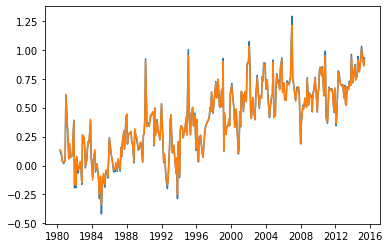

In [213]:
plt.plot(y.index, y)
plt.plot(y.index, y_pred_train)

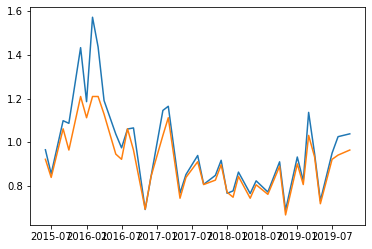

In [214]:
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_pred)

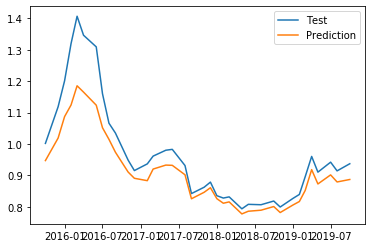

In [215]:
mean_test = y_test.rolling(4).mean()
mean_pred = pd.Series(y_pred, index=mean_test.index).rolling(4).mean()
plt.plot(mean_test.index, mean_test, label='Test')
plt.plot(mean_pred.index, mean_pred, label='Prediction')
plt.legend(loc='best')

Learning: The BDT has no problem to use the large correlation between global temperatures to predict the temperature at a given point of time. This is NOT a forecast of any means, thoug!

### 2: Using a Recurrent Neural Network

In [216]:
def reshape_keras(X, look_back=6):
    return (
        np.array([X.values[i:-(look_back-i)] for i in range(look_back)])
        .reshape(X.shape[0] - look_back, look_back, X.shape[1])
    )

In [235]:
look_back = 3

In [236]:
model = Sequential()
model.add(TimeDistributed(Dense(10), input_shape=(look_back, X.shape[1])))
model.add(LSTM(5, return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile('adam', loss='mean_squared_error')

In [237]:
X_keras = reshape_keras(X, look_back)

In [238]:
y_keras = np.array([y.values[i:-(look_back-i)] for i in range(look_back)]).reshape(y.shape[0] - look_back, look_back, 1)

In [239]:
model.fit(X_keras, y_keras, epochs=1000, verbose=False)

In [240]:
y_pred_train_keras = model.predict(X_keras)

In [241]:
y_pred_train_keras.shape

(297, 3, 1)

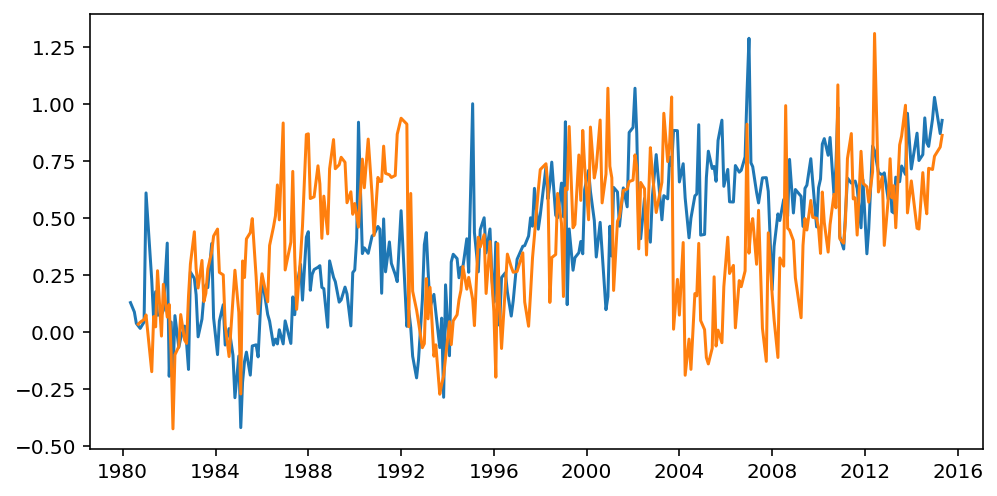

In [244]:
plt.figure(figsize=(8, 4), dpi=144)
plt.plot(y.index, y)
plt.plot(y[look_back:].index, y_pred_train_keras[:,-1,0])

In [249]:
y_pred_keras = model.predict(reshape_keras(X.append(X_test), look_back))

In [250]:
y_all = y.append(y_test)

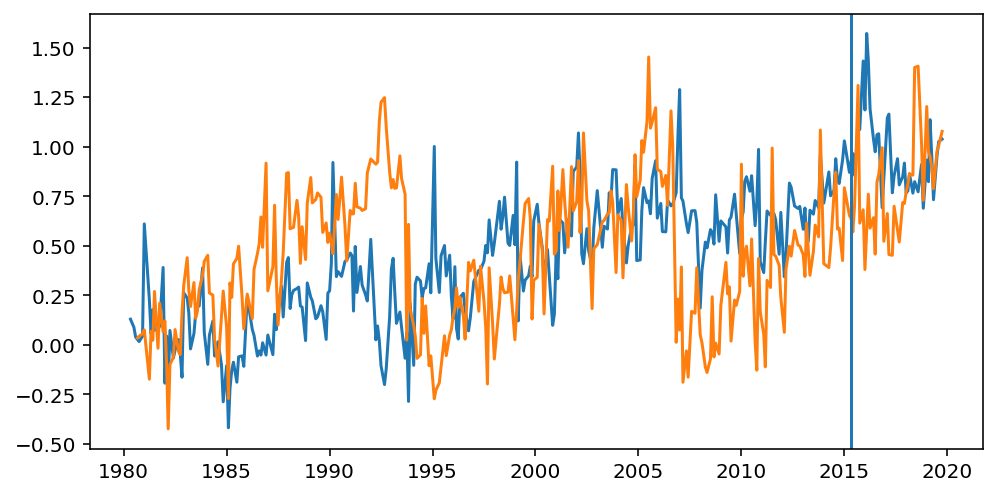

In [253]:
plt.figure(figsize=(8, 4), dpi=144)
plt.plot(y_all.index, y_all)
plt.plot(y_all[look_back:].index, y_pred_keras[:,-1,0])
plt.axvline(y.iloc[-1:].index)

Now we are predicting one month ahead, by looking at the the current month.